# Trabajo Grupal: Percepción Computacional
**Nombres:** Daniel Proaño, Santiago Luna, Diana Romero

Vinculación con google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Cargar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray, label2rgb, rgb2hsv, hsv2rgb
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import (active_contour, felzenszwalb, quickshift, 
                                 mark_boundaries, slic, clear_border)

from skimage.future.graph import rag_mean_color, cut_normalized
import io

from itertools import product

In [0]:
# Defino una función para mostrar una imagen por pantalla con el criterio que considero más acertado
def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    # El comando que realmente muestra la imagen
    ax.imshow(img,cmap=plt.cm.gray)
    # Para evitar que aparezcan los números en los ejes
    ax.set_xticks([]), ax.set_yticks([])
    plt.show()

In [0]:
# Función para comparar cómo de buena es una determinada segmentación en comparación con el ground truth
# Ambas imagenes deben contener valores True/False
def factor_f_evaluation(binary_image, ground_truth):
    TP = np.sum(np.logical_and(binary_image, ground_truth))
    TN = np.sum(np.logical_and(np.logical_not(binary_image), np.logical_not(ground_truth)))
    FP = np.sum(np.logical_and(np.logical_not(binary_image), ground_truth))
    FN = np.sum(np.logical_and(binary_image, np.logical_not(ground_truth)))
    P = TP/np.float(TP+FP)
    R = TP/np.float(TP+FN)
    if P+R == 0:
        F = 0
    else:
        F = 2*P*R/(P+R)
    return F

Cargar las Imágenes en Variables para su procesamiento

In [0]:
patos = data.imread('/content/drive/My Drive/Colab Notebooks/ducks01_0100.jpg')
gt_patos = rgb2gray(data.imread('/content/drive/My Drive/Colab Notebooks/ducks01_0100_gt.ppm'))<1

Muestra la Imagen inicial que será procesada

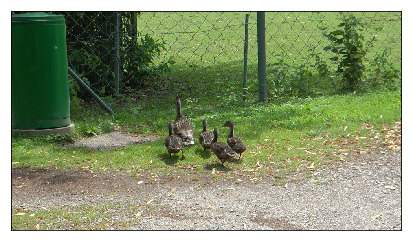

In [6]:
imshow(patos)

Muestra el objetivo de la segmentación

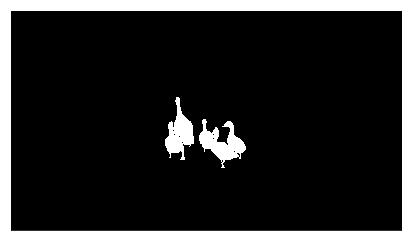

In [7]:
imshow(gt_patos)

In [0]:
#Se intentó ejecutar un realce de imagen por histograma pero afecta negativamente a la segmentación
histogram, bin_edges = np.histogram(patos, bins=256, range=(0, 255))
cdf=histogram.cumsum()
cdf_normalized = cdf * histogram.max()/ cdf.max()
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = 255-((cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min()))
cdf = np.ma.filled(cdf_m,0).astype('uint8')
img2 = cdf[patos]
patos2=img2

Separación Por Capas en RGB para encontrar el que sea más sencillo para segmentar



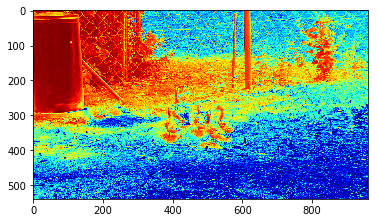

In [9]:
plt.imshow(patos2[:,:,0],cmap = 'jet')

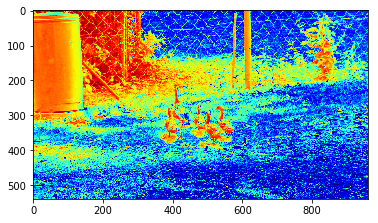

In [10]:
plt.imshow(patos2[:,:,1],cmap = 'jet')

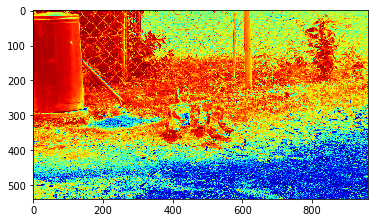

In [11]:
plt.imshow(patos2[:,:,2],cmap = 'jet')

Separación por capas en HSV para comparar con las capas separadas en RGB

In [0]:
patos_hsv = rgb2hsv(patos2)

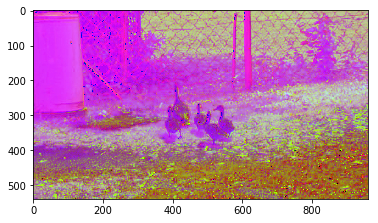

In [14]:
plt.imshow(patos_hsv)

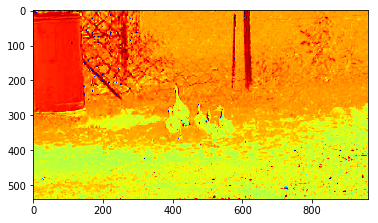

In [15]:
plt.imshow(patos_hsv[:,:,0],cmap = 'jet')

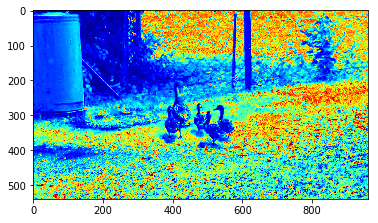

In [16]:
plt.imshow(patos_hsv[:,:,1],cmap = 'jet')

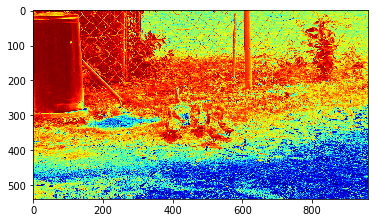

In [17]:
plt.imshow(patos_hsv[:,:,2],cmap = 'jet')

Se elije trabajar con patos_hsv[:,:,0] por su mejor distinción con el entorno del objetivo, el siguiente paso es filtrar la imagen

> Bloc con sangría



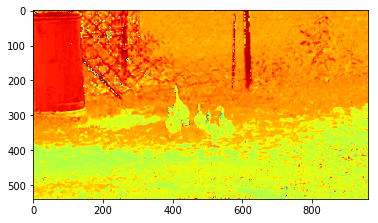

In [18]:
patos_hsv_mod = gaussian(patos_hsv[:,:,0], 1)
plt.imshow(patos_hsv_mod, cmap = 'jet')

**Detector Binario Otsu**, método basado en segmentación por histograma

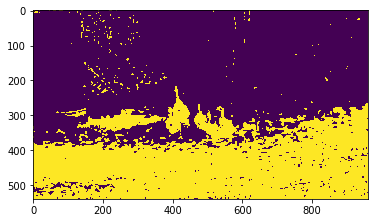

In [19]:
from skimage import filters
im = patos_hsv_mod
val = filters.threshold_otsu(im)
mask = im < val
plt.imshow(mask)

Aplicación de morfología matemática

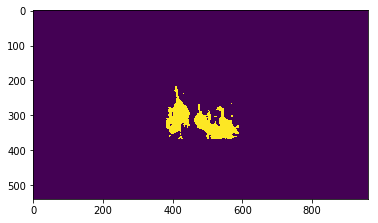

In [20]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import disk
selem = disk(2)
closed = closing(mask, selem)
closed[370:,:]=0
closed[:210,:]=0
closed[:,:380]=0
closed[:,590:]=0
plt.imshow(closed)

Evaluación de la función

In [21]:
factor_f_evaluation(closed,gt_patos)

0.8908972409298284

Histograma de la imagen

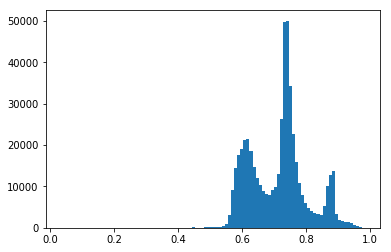

In [22]:
image = patos_hsv_mod
ax = plt.hist(image.ravel(), bins = 100)
plt.show()

Segmentación por **slic**

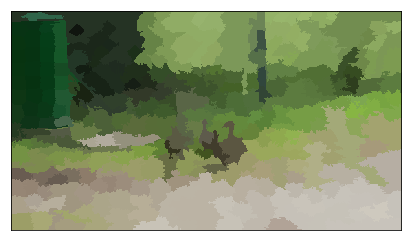

In [23]:
patos_slic = slic(patos,n_segments=500)
imshow(label2rgb(patos_slic, patos, kind='avg'));

No se siguió trabajando con esta segmentación ya que al momento de binarizar causaba inconvenientes

Librerías para trabajar con Agregación Multiescala

In [0]:
from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np


def _weight_mean_color(graph, src, dst, n):
    """Callback to handle merging nodes by recomputing mean color.

    The method expects that the mean color of `dst` is already computed.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the `"weight"` attribute set as the absolute
        difference of the mean color between node `dst` and `n`.
    """

    diff = graph.node[dst]['mean color'] - graph.node[n]['mean color']
    diff = np.linalg.norm(diff)
    return {'weight': diff}

In [0]:
def merge_mean_color(graph, src, dst):
    """Callback called before merging two nodes of a mean color distance graph.

    This method computes the mean color of `dst`.

    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    """
    graph.node[dst]['total color'] += graph.node[src]['total color']
    graph.node[dst]['pixel count'] += graph.node[src]['pixel count']
    graph.node[dst]['mean color'] = (graph.node[dst]['total color'] /
                                     graph.node[dst]['pixel count'])

Segmentación de la imagen y gración de grafos

In [0]:
img = patos
labels = segmentation.slic(img, compactness=30, n_segments=250)
g = graph.rag_mean_color(img, labels)

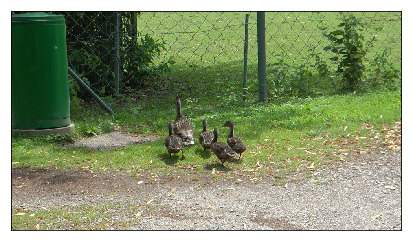

In [27]:
imshow(img)

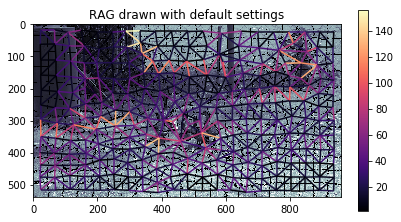

In [28]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax)
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax)

Se elije el umbral para la selección de nodos

In [0]:
labels2 = graph.merge_hierarchical(labels, g, thresh=20, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_mean_color,
                                   weight_func=_weight_mean_color)

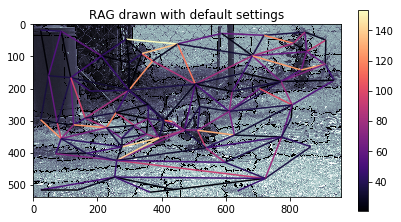

In [30]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 8))

ax.set_title('RAG drawn with default settings')
lc = graph.show_rag(labels, g, img, ax=ax)
# specify the fraction of the plot area that will be used to draw the colorbar
fig.colorbar(lc, fraction=0.03, ax=ax)

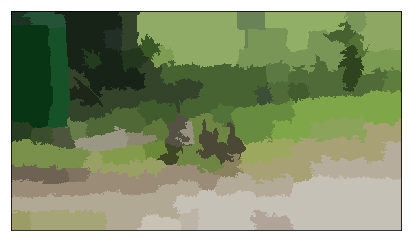

In [31]:
out = color.label2rgb(labels2, img, kind='avg')
#out = segmentation.mark_boundaries(out, labels2, (0, 0, 0))
imshow(out)

Se toma la capa de color que mejor segmente al objetivo deseado

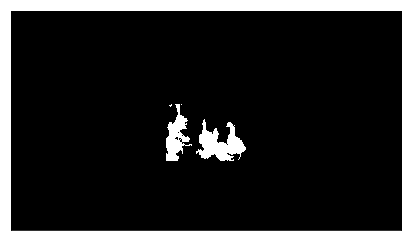

In [32]:
bin_out=out[:,:,1] < 82
bin_out[370:,:]=0
bin_out[:230,:]=0
bin_out[:,:380]=0
bin_out[:,590:]=0
imshow(bin_out)

Se analiza la Función

In [33]:
factor_f_evaluation(bin_out,gt_patos)

0.8168823555936329

# Resultado esperado

In [0]:
Resultado de la segmentacion

In [0]:
Resultado final